In [1]:
import pandas as pd
import numpy as np
import sqlite3
import altair as alt
import scipy.interpolate as interpolate
from scipy.stats import skewnorm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from scipy.stats import chi2

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
con = sqlite3.connect("switrs.sqlite")

query = """
    SELECT * FROM collisions WHERE county_location = 'los angeles'
    """

df = pd.read_sql_query(query, con, parse_dates = ["collision_date"])
df["year"] = df["collision_date"].dt.year
df["hour"] = pd.to_datetime(df["collision_time"]).dt.hour
df = df.query("year < 2021") # remove incomplete 2021 data
df["alcohol_involved"] = df["alcohol_involved"].fillna(0) # convert NaN to 0 in alcohol use column

dfc = df[["case_id", "county_location", "alcohol_involved", "collision_severity", "injured_victims", "collision_date", "year", "collision_time", "hour", "party_count"]]

con.close()

/var/folders/vm/ch_70xjd3t1_t3h7108v_7x80000gn/T/ipykernel_1287/2772648188.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour"] = pd.to_datetime(df["collision_time"]).dt.hour


In [7]:
# Create a copy of the dataframe
dfrf = df.copy()
dfrf = dfrf[dfrf['year'] == 2020]

dfrf["minute"] = pd.to_datetime(df["collision_time"], format = "%H:%M:%S").dt.minute
dfrf["day"] = pd.to_datetime(df["collision_time"], format = "%H:%M:%S").dt.day_of_year


drop_feats = ["collision_severity", "killed_victims", "injured_victims", "severe_injury_count",
              "other_visible_injury_count", "complaint_of_pain_injury_count", "pedestrian_killed_count", "pedestrian_injured_count",
              "bicyclist_killed_count", "bicyclist_injured_count", "motorcyclist_killed_count", "motorcyclist_injured_count",
              "case_id", "process_date", "hour", "collision_date", "process_date", "collision_time",
              "city_division_lapd"]

dfnan = pd.DataFrame()
dfnan["predictor"] = (dfrf.isna().sum() / dfrf.isna().count()).sort_values().index
dfnan["p_nan"] = (dfrf.isna().sum() / dfrf.isna().count()).sort_values().values

drop_nans = dfnan.query("p_nan > 0.8")["predictor"] # drop features that are more than 80 % nan

X = dfrf.drop(drop_feats, axis = 1).drop(drop_nans, axis = 1).convert_dtypes()

numcols = []
for column in X:
    if X[column].dtype != "string[python]":
        numcols.append(column)
badnumcols = [column for column in numcols if column not in ["distance", "party_count", "latitude", "longitude", "year", "minute", "day"]] # only keep these ones as numeric
X[badnumcols] = X[badnumcols].astype("string[python]")

badcats = [column for column in X if X[column].nunique() > 100 and X[column].dtype == "string[python]"]
X = X.drop(badcats, axis = 1) # drop categorical features with more than 100 unique groups

In [33]:
# One-hot encode categorical variables
Xoh = pd.get_dummies(X)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data and transform it, then convert back to DataFrame
Xoh_imputed = imputer.fit_transform(Xoh)
Xoh_imputed = pd.DataFrame(Xoh_imputed, columns=Xoh.columns)

# Define the target variable
y = dfrf["injured_victims"].fillna(0) 

# Split the data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(Xoh_imputed, y, random_state=13)

# Initialize the Lasso model
lasso = Lasso(alpha=0.1, random_state=13)

# Fit the Lasso model
lasso.fit(X_tr, y_tr)

# Predict on the test set
lasso_pred = lasso.predict(X_te)

# Calculate and print RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_te, lasso_pred))
print(f"Lasso RMSE: {rmse_lasso:.3f}")

# Show the coefficients of the features to understand feature importance
feature_importance_lasso = pd.DataFrame({
    "feature": X_tr.columns, 
    "coefficient": np.abs(lasso.coef_)
}).sort_values("coefficient", ascending=False)

# Print the top 20 most important features
print("Top Features (by absolute coefficient value):")
print(feature_importance_lasso.head(20))


Lasso RMSE: 0.853
Top Features (by absolute coefficient value):
                                               feature  coefficient
247                            hit_and_run_misdemeanor     0.127149
1                                          party_count     0.000351
5                                               minute     0.000260
0                                             distance     0.000026
393  chp_vehicle_type_at_fault_two-axle truck: haza...     0.000000
248                        hit_and_run_not hit and run     0.000000
270  pedestrian_action_crossing in intersection cro...     0.000000
269                  motor_vehicle_involved_with_train     0.000000
268             motor_vehicle_involved_with_pedestrian     0.000000
267   motor_vehicle_involved_with_parked motor vehicle     0.000000
266           motor_vehicle_involved_with_other object     0.000000
265    motor_vehicle_involved_with_other motor vehicle     0.000000
264          motor_vehicle_involved_with_non-collisi

In [35]:
Xoh2 = pd.get_dummies(X.drop("party_count", axis = 1))
y2 = dfrf["injured_victims"].fillna(0) / dfrf["party_count"].fillna(1)

# Fit the imputer to the data and transform it, then convert back to DataFrame
Xoh2_imputed = imputer.fit_transform(Xoh2)
Xoh2_imputed = pd.DataFrame(Xoh2_imputed, columns=Xoh2.columns)

# Split the data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(Xoh2_imputed, y2, random_state=13)

# Initialize the Lasso model
lasso = Lasso(alpha=0.1, random_state=13)

# Fit the Lasso model
lasso.fit(X_tr, y_tr)

# Predict on the test set
lasso_pred = lasso.predict(X_te)

# Calculate and print RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_te, lasso_pred))
print(f"Lasso RMSE: {rmse_lasso:.3f}")

# Show the coefficients of the features to understand feature importance
feature_importance_lasso = pd.DataFrame({
    "feature": X_tr.columns, 
    "coefficient": np.abs(lasso.coef_)
}).sort_values("coefficient", ascending=False)

# Print the top 20 most important features
print("Top Features (by absolute coefficient value):")
print(feature_importance_lasso.head(20))


Lasso RMSE: 0.438
Top Features (by absolute coefficient value):
                                               feature   coefficient
0                                             distance  4.693404e-07
272                          pedestrian_action_in road  0.000000e+00
270  pedestrian_action_crossing non-intersection cr...  0.000000e+00
269  pedestrian_action_crossing in intersection cro...  0.000000e+00
268                  motor_vehicle_involved_with_train  0.000000e+00
267             motor_vehicle_involved_with_pedestrian  0.000000e+00
266   motor_vehicle_involved_with_parked motor vehicle  0.000000e+00
265           motor_vehicle_involved_with_other object  0.000000e+00
264    motor_vehicle_involved_with_other motor vehicle  0.000000e+00
263          motor_vehicle_involved_with_non-collision  0.000000e+00
262  motor_vehicle_involved_with_motor vehicle on o...  0.000000e+00
261           motor_vehicle_involved_with_fixed object  0.000000e+00
260                motor_vehicle_involv

In [47]:
feature_importance_lasso = pd.DataFrame({
    "feature": X_tr.columns, 
    "coefficient": lasso.coef_
}).sort_values("coefficient", ascending=False)

feature_importance_lasso[feature_importance_lasso['feature'] == 'distance']

,feature,coefficient
0,distance,4.693404e-07


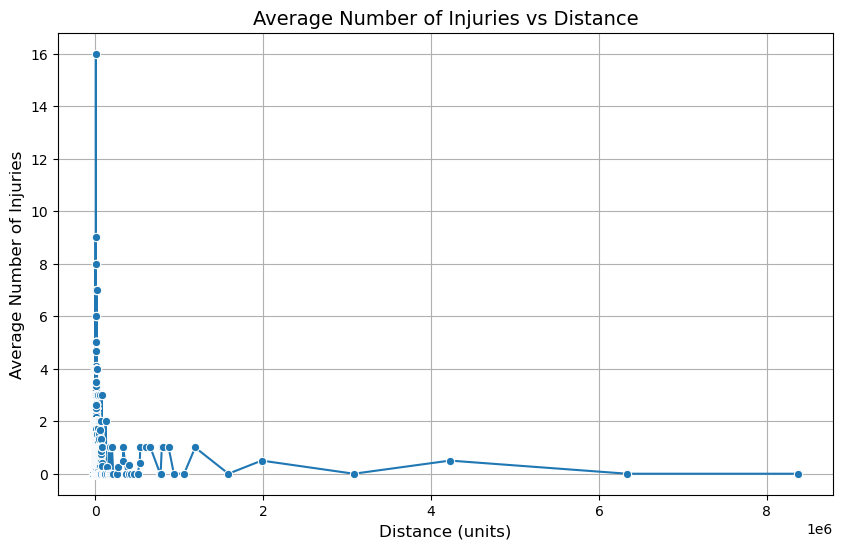

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is your DataFrame, and it has 'distance' and 'injuries' columns
# Group by 'distance' and calculate the average number of injuries
average_injuries_by_distance = df.groupby('distance')['injured_victims'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_injuries_by_distance, x='distance', y='injured_victims', marker='o')

# Adding labels and title
plt.title('Average Number of Injuries vs Distance', fontsize=14)
plt.xlabel('Distance (units)', fontsize=12)
plt.ylabel('Average Number of Injuries', fontsize=12)
plt.grid(True)
plt.show()

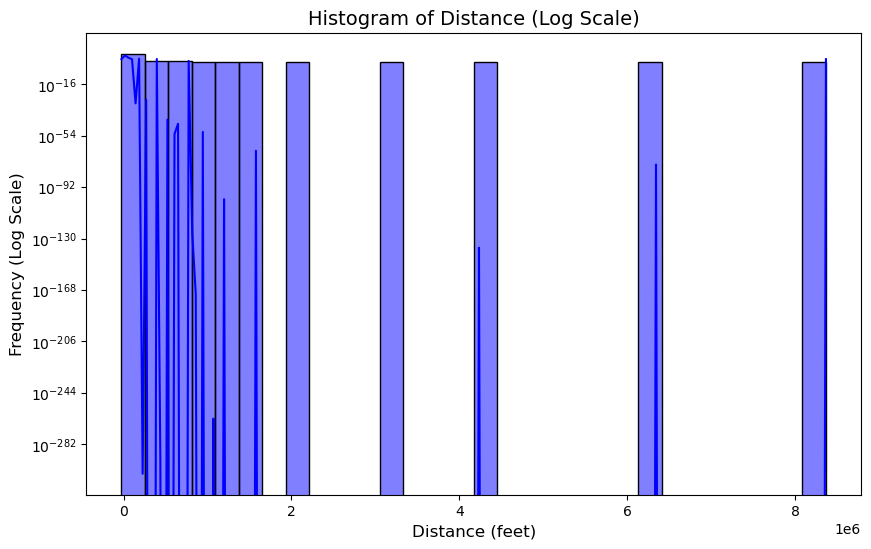

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains a column 'distance'
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.histplot(df['distance'], bins=30, kde=True, color='blue')  # Plot histogram with KDE (Kernel Density Estimation)

# Scaling the y-axis to logarithmic scale (useful for data with a wide range of frequencies)
plt.yscale('log')  # This will scale the y-axis to a logarithmic scale

# Adding labels and title
plt.title('Histogram of Distance (Log Scale)', fontsize=14)
plt.xlabel('Distance (feet)', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)

# Show the plot
plt.show()


In [57]:
# Get the minimum and maximum values of the "distance" column
min_distance = df['distance'].min()
max_distance = df['distance'].max()

# Print the range of the "distance" variable
print(f"The range of 'distance' is from {min_distance} to {max_distance}")


The range of 'distance' is from -26400.0 to 8368800.0


In [61]:
from sklearn.preprocessing import StandardScaler

# List of numeric columns
numcols = [column for column in X.columns if X[column].dtype != "string[python]"]

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the numeric columns
X_scaled = X.copy()  # Create a copy to preserve the original data
X_scaled[numcols] = scaler.fit_transform(X[numcols])



In [63]:
# One-hot encode categorical variables
Xoh = pd.get_dummies(X_scaled)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data and transform it, then convert back to DataFrame
Xoh_imputed = imputer.fit_transform(Xoh)
Xoh_imputed = pd.DataFrame(Xoh_imputed, columns=Xoh.columns)

# Define the target variable
y = dfrf["injured_victims"].fillna(0) 

# Split the data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(Xoh_imputed, y, random_state=13)

# Initialize the Lasso model
lasso = Lasso(alpha=0.1, random_state=13)

# Fit the Lasso model
lasso.fit(X_tr, y_tr)

# Predict on the test set
lasso_pred = lasso.predict(X_te)

# Calculate and print RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_te, lasso_pred))
print(f"Lasso RMSE: {rmse_lasso:.3f}")

# Show the coefficients of the features to understand feature importance
feature_importance_lasso = pd.DataFrame({
    "feature": X_tr.columns, 
    "coefficient": np.abs(lasso.coef_)
}).sort_values("coefficient", ascending=False)

# Print the top 20 most important features
print("Top Features (by absolute coefficient value):")
print(feature_importance_lasso.head(20))

Lasso RMSE: 0.848
Top Features (by absolute coefficient value):
                                               feature  coefficient
247                            hit_and_run_misdemeanor     0.126552
1                                          party_count     0.045206
200                                         tow_away_0     0.000000
249                                type_of_collision_I     0.000000
271  pedestrian_action_crossing non-intersection cr...     0.000000
270  pedestrian_action_crossing in intersection cro...     0.000000
269                  motor_vehicle_involved_with_train     0.000000
268             motor_vehicle_involved_with_pedestrian     0.000000
267   motor_vehicle_involved_with_parked motor vehicle     0.000000
266           motor_vehicle_involved_with_other object     0.000000
265    motor_vehicle_involved_with_other motor vehicle     0.000000
264          motor_vehicle_involved_with_non-collision     0.000000
263  motor_vehicle_involved_with_motor vehicle on o.

In [65]:
Xoh2 = pd.get_dummies(X_scaled.drop("party_count", axis = 1))
y2 = dfrf["injured_victims"].fillna(0) / dfrf["party_count"].fillna(1)

# Fit the imputer to the data and transform it, then convert back to DataFrame
Xoh2_imputed = imputer.fit_transform(Xoh2)
Xoh2_imputed = pd.DataFrame(Xoh2_imputed, columns=Xoh2.columns)

# Split the data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(Xoh2_imputed, y2, random_state=13)

# Initialize the Lasso model
lasso = Lasso(alpha=0.1, random_state=13)

# Fit the Lasso model
lasso.fit(X_tr, y_tr)

# Predict on the test set
lasso_pred = lasso.predict(X_te)

# Calculate and print RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_te, lasso_pred))
print(f"Lasso RMSE: {rmse_lasso:.3f}")

# Show the coefficients of the features to understand feature importance
feature_importance_lasso = pd.DataFrame({
    "feature": X_tr.columns, 
    "coefficient": np.abs(lasso.coef_)
}).sort_values("coefficient", ascending=False)

# Print the top 20 most important features
print("Top Features (by absolute coefficient value):")
print(feature_importance_lasso.head(20))


Lasso RMSE: 0.438
Top Features (by absolute coefficient value):
                                               feature  coefficient
0                                             distance          0.0
272                          pedestrian_action_in road          0.0
270  pedestrian_action_crossing non-intersection cr...          0.0
269  pedestrian_action_crossing in intersection cro...          0.0
268                  motor_vehicle_involved_with_train          0.0
267             motor_vehicle_involved_with_pedestrian          0.0
266   motor_vehicle_involved_with_parked motor vehicle          0.0
265           motor_vehicle_involved_with_other object          0.0
264    motor_vehicle_involved_with_other motor vehicle          0.0
263          motor_vehicle_involved_with_non-collision          0.0
262  motor_vehicle_involved_with_motor vehicle on o...          0.0
261           motor_vehicle_involved_with_fixed object          0.0
260                motor_vehicle_involved_with_bicyc